## Necessary Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import re
import pandas as pd
import numpy as np
from functools import reduce
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict, acf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

## Loading Data

In [ ]:
df = pd.read_csv('data/FINANCIAL DATA of UK SMEs.csv')

In [ ]:
pd.options.display.max_columns = None

In [ ]:
df

,SMEs,Location,Activity,"Turnover January,2018 (Pounds in millions)","Pre-tax Profit January,2018 (Pounds in millions)",Tax 2018 (Pounds in millions),"No of Employee January,2018","Turnover Febuary,2018 (Pounds in millions)","Pre-tax Profit Febuary,2018 (Pounds in millions)","Tax Febuary,2018 (Pounds in millions)","No of Employee Febuary,2018","Turnover March,2018 (Pounds in millions)","Pre-tax Profit March,2018 (Pounds in millions)","Tax March,2018 (Pounds in millions)","No of Employee March,2018","Pre-tax Profit April,2018 (Pounds in millions)","Tax April,2018 (Pounds in millions)","No of Employee April,2018","Turnover May,2018 (Pounds in millions)","Pre-tax Profit May,2018 (Pounds in millions)","Tax May,2018 (Pounds in millions)","No of Employee May,2018","Turnover June,2018 (Pounds in millions)","Pre-tax Profit June,2018 (Pounds in millions)","Tax June,2018 (Pounds in millions)","No of Employee June,2018","Turnover July,2018 (Pounds in millions)","Pre-tax Profit July,2018 (Pounds in millions)","Tax July,2018 (Pounds in millions)","No of Employee July,2018","Turnover August,2018 (Pounds in millions)","Pre-tax Profit August,2018 (Pounds in millions)","Tax August,2018 (Pounds in millions)","No of Employee August,2018","Turnover September,2018 (Pounds in millions)","Pre-tax Profit September,2018 (Pounds in millions)","Tax September,2018 (Pounds in millions)","No of Employee September,2018","Turnover October,2018 (Pounds in millions)","Pre-tax Profit October,2018 (Pounds in millions)","Tax October,2018 (Pounds in millions)","No of Employee October,2018","Turnover November,2018 (Pounds in millions)","Pre-tax Profit November,2018 (Pounds in millions)","Tax November,2018 (Pounds in millions)","No of Employee November,2018","Turnover December,2018 (Pounds in millions)","Pre-tax Profit December,2018 (Pounds in millions)","Tax December,2018 (Pounds in millions)","No of Employee December,2018","Turnover January,2019 (Pounds in millions)","Pre-tax Profit January,2019 (Pounds in millions)","Tax January,2019 (Pounds in millions)","No of Employee January,2019","Turnover Febuary,2019 (Pounds in millions)","Pre-tax Profit Febaury,2019 (Pounds in millions)","Tax Febuary,2019 (Pounds in millions)","No of Employee Febuary,2019","Turnover March,2019 (Pounds in millions)","Pre-tax Profit March,2019 (Pounds in millions)","Tax March,2019 (Pounds in millions)","No of Employee March,2019","Turnover April,2019 (Pounds in millions)","Pre-tax Profit April,2019 (Pounds in millions)","Tax April,2019 (Pounds in millions)","No of Employee April,2019","Turnover May,2019 (Pounds in millions)","Pre-tax Profit May,2019 (Pounds in millions)","Tax May,2019 (Pounds in millions)","No of Employee May,2019","Turnover June,2019 (Pounds in millions)","Pre-tax Profit June,2019 (Pounds in millions)","Tax June,2019 (Pounds in millions)","No of Employee June,2019","Turnover July,2019 (Pounds in millions)","Pre-tax Profit July,2019 (Pounds in millions)","Tax July,2019 (Pounds in millions)","No of Employee July,2019","Turnover August,2019 (Pounds in millions)","Pre-tax Profit August,2019 (Pounds in millions)","Tax August,2019 (Pounds in millions)","No of Employee August,2019","Turnover September,2019 (Pounds in millions)","Pre-tax Profit Semptember,2019 (Pounds in millions)","Tax September,2019 (Pounds in millions)","No of Employee September,2019","Turnover October,2019 (Pounds in millions)","Pre-tax Profit October,2019 (Pounds in millions)","Tax October,2019 (Pounds in millions)","No of Employee October,2019","Turnover November,2019 (Pounds in millions)","Pre-tax Profit November,2019 (Pounds in millions)","Tax November,2019 (Pounds in millions)","No of Employee November,2019","Turnover December,2019 (Pounds in millions)","Pre-tax Profit December,2019 (Pounds in millions)","Tax December,2019 (Pounds in millions)","No of Employee December,2019","Turnover January,2020 (Pounds in millions)","Pre-tax Profit January,2020 (Pounds in millions)","Tax Janauary,2020 (Pounds in millio

In [ ]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 251 columns):
 #    Column                                               Non-Null Count  Dtype  
---   ------                                               --------------  -----  
 0    SMEs                                                 248 non-null    object 
 1    Location                                             248 non-null    object 
 2    Activity                                             248 non-null    object 
 3    Turnover January,2018 (Pounds in millions)           248 non-null    object 
 4    Pre-tax Profit January,2018 (Pounds in millions)     248 non-null    float64
 5    Tax 2018 (Pounds in millions)                        248 non-null    float64
 6    No of Employee January,2018                          248 non-null    float64
 7    Turnover Febuary,2018 (Pounds in millions)           248 non-null    float64
 8    Pre-tax Profit Febuary,2018 (Pounds in millions)     248 n

## Cleaning Data

In [ ]:
# Dropping nameless column
df.drop('Unnamed: 250', axis=1, inplace=True)

# Dropping last row
df.drop(248, inplace=True)

# Showing Dataframe info
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 250 columns):
 #    Column                                               Non-Null Count  Dtype  
---   ------                                               --------------  -----  
 0    SMEs                                                 248 non-null    object 
 1    Location                                             248 non-null    object 
 2    Activity                                             248 non-null    object 
 3    Turnover January,2018 (Pounds in millions)           248 non-null    object 
 4    Pre-tax Profit January,2018 (Pounds in millions)     248 non-null    float64
 5    Tax 2018 (Pounds in millions)                        248 non-null    float64
 6    No of Employee January,2018                          248 non-null    float64
 7    Turnover Febuary,2018 (Pounds in millions)           248 non-null    float64
 8    Pre-tax Profit Febuary,2018 (Pounds in millions)     248 n

In [ ]:
# Renaming first Tax column
df = df.rename(columns={'Tax 2018 (Pounds in millions) ': 'Tax January,2018 (Pounds in millions)'})

# replace 'Febuary' with 'February' in column names
df.columns = df.columns.str.replace('Febuary', 'February')

In [ ]:
# showing cleaned df
df

,SMEs,Location,Activity,"Turnover January,2018 (Pounds in millions)","Pre-tax Profit January,2018 (Pounds in millions)","Tax January,2018 (Pounds in millions)","No of Employee January,2018","Turnover February,2018 (Pounds in millions)","Pre-tax Profit February,2018 (Pounds in millions)","Tax February,2018 (Pounds in millions)","No of Employee February,2018","Turnover March,2018 (Pounds in millions)","Pre-tax Profit March,2018 (Pounds in millions)","Tax March,2018 (Pounds in millions)","No of Employee March,2018","Pre-tax Profit April,2018 (Pounds in millions)","Tax April,2018 (Pounds in millions)","No of Employee April,2018","Turnover May,2018 (Pounds in millions)","Pre-tax Profit May,2018 (Pounds in millions)","Tax May,2018 (Pounds in millions)","No of Employee May,2018","Turnover June,2018 (Pounds in millions)","Pre-tax Profit June,2018 (Pounds in millions)","Tax June,2018 (Pounds in millions)","No of Employee June,2018","Turnover July,2018 (Pounds in millions)","Pre-tax Profit July,2018 (Pounds in millions)","Tax July,2018 (Pounds in millions)","No of Employee July,2018","Turnover August,2018 (Pounds in millions)","Pre-tax Profit August,2018 (Pounds in millions)","Tax August,2018 (Pounds in millions)","No of Employee August,2018","Turnover September,2018 (Pounds in millions)","Pre-tax Profit September,2018 (Pounds in millions)","Tax September,2018 (Pounds in millions)","No of Employee September,2018","Turnover October,2018 (Pounds in millions)","Pre-tax Profit October,2018 (Pounds in millions)","Tax October,2018 (Pounds in millions)","No of Employee October,2018","Turnover November,2018 (Pounds in millions)","Pre-tax Profit November,2018 (Pounds in millions)","Tax November,2018 (Pounds in millions)","No of Employee November,2018","Turnover December,2018 (Pounds in millions)","Pre-tax Profit December,2018 (Pounds in millions)","Tax December,2018 (Pounds in millions)","No of Employee December,2018","Turnover January,2019 (Pounds in millions)","Pre-tax Profit January,2019 (Pounds in millions)","Tax January,2019 (Pounds in millions)","No of Employee January,2019","Turnover February,2019 (Pounds in millions)","Pre-tax Profit Febaury,2019 (Pounds in millions)","Tax February,2019 (Pounds in millions)","No of Employee February,2019","Turnover March,2019 (Pounds in millions)","Pre-tax Profit March,2019 (Pounds in millions)","Tax March,2019 (Pounds in millions)","No of Employee March,2019","Turnover April,2019 (Pounds in millions)","Pre-tax Profit April,2019 (Pounds in millions)","Tax April,2019 (Pounds in millions)","No of Employee April,2019","Turnover May,2019 (Pounds in millions)","Pre-tax Profit May,2019 (Pounds in millions)","Tax May,2019 (Pounds in millions)","No of Employee May,2019","Turnover June,2019 (Pounds in millions)","Pre-tax Profit June,2019 (Pounds in millions)","Tax June,2019 (Pounds in millions)","No of Employee June,2019","Turnover July,2019 (Pounds in millions)","Pre-tax Profit July,2019 (Pounds in millions)","Tax July,2019 (Pounds in millions)","No of Employee July,2019","Turnover August,2019 (Pounds in millions)","Pre-tax Profit August,2019 (Pounds in millions)","Tax August,2019 (Pounds in millions)","No of Employee August,2019","Turnover September,2019 (Pounds in millions)","Pre-tax Profit Semptember,2019 (Pounds in millions)","Tax September,2019 (Pounds in millions)","No of Employee September,2019","Turnover October,2019 (Pounds in millions)","Pre-tax Profit October,2019 (Pounds in millions)","Tax October,2019 (Pounds in millions)","No of Employee October,2019","Turnover November,2019 (Pounds in millions)","Pre-tax Profit November,2019 (Pounds in millions)","Tax November,2019 (Pounds in millions)","No of Employee November,2019","Turnover December,2019 (Pounds in millions)","Pre-tax Profit December,2019 (Pounds in millions)","Tax December,2019 (Pounds in millions)","No of Employee December,2019","Turnover January,2020 (Pounds in millions)","Pre-tax Profit January,2020 (Pounds in millions)","Tax Janauary,2020 

## Transposing Data

In [ ]:
# Select columns starting with 'Turnover'
turnover_cols = [col for col in df.columns if col.startswith('Turnover')]

# Remove commas and convert to float
df[turnover_cols] = df[turnover_cols].replace(',', '', regex=True).astype(float)

In [ ]:
# Define the prefix of concerned columns
col_prefix = ['Turnover', 'Pre-tax', 'Tax', 'No of Employee']

# Define the ID variables
id_vars = ['SMEs', 'Location', 'Activity']

# dict to hold transposed col_prefix columns
transposed_cols = {}

for prefix in col_prefix:
  # Define the month columns to melt
  month_cols = [col for col in df.columns if col.startswith(prefix)]

  # Melt the data into a long format
  transposed_cols[prefix] = pd.melt(df, id_vars=id_vars, value_vars=month_cols, var_name='Month', value_name=prefix)

  # extract year from Month column using regex
  transposed_cols[prefix]['Year'] = transposed_cols[prefix]['Month'].str.extract('(\d{4})', expand=False)

  # define the regex pattern
  pattern = r'(?i)(january|february|march|april|may|june|july|august|september|october|november|december)'

  # apply regex to extract only the month name
  transposed_cols[prefix]['Month'] = transposed_cols[prefix]['Month'].str.extract(pattern)

# Define the columns to merge on
merge_cols = ['SMEs', 'Location', 'Activity', 'Month', 'Year']

# Perform a left join to merge all the DataFrames in the dictionary
#merged_df = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how='left'),
#                   transposed_cols.values())

# Merge all the DataFrames in the dictionary
merged_df = transposed_cols[col_prefix[0]]
for prefix in col_prefix[1:]:
  merged_df = pd.merge(merged_df, transposed_cols[prefix], on=merge_cols, how='left')



# merged_df['Month'] = merged_df['Month'].astype('int')
# merged_df['Year'] = merged_df['Year'].astype('int')
#merged_df['Turnover'] = merged_df['Turnover'].str.replace(',','')
#merged_df['Turnover'] = merged_df['Turnover'].astype('float')


merged_df = merged_df.reindex(columns=['SMEs', 'Location', 'Activity', 'Month', 'Year', 'Turnover', 'Pre-tax', 'Tax', 'No of Employee'])

# Drop duplicate rows in the original dataframe
merged_df = merged_df.drop_duplicates()

# Merge the dataframes
merged_df = pd.merge(merged_df, transposed_cols['Turnover'], on=merge_cols, how='left')
merged_df = pd.merge(merged_df, transposed_cols['Pre-tax'], on=merge_cols, how='left')
merged_df = pd.merge(merged_df, transposed_cols['Tax'], on=merge_cols, how='left')
merged_df = pd.merge(merged_df, transposed_cols['No of Employee'], on=merge_cols, how='left')

merged_df=merged_df.drop_duplicates()

# Drop columns with '_x'
merged_df = merged_df.filter(regex='^(?!.*_x)')

# Rename columns with '_y'
merged_df = merged_df.rename(columns=lambda col: col.replace('_y', ''))

#merged_df['Turnover'] = merged_df['Turnover'].str.replace(',','')
#merged_df['Turnover'] = merged_df['Turnover'].astype('float')

merged_df = merged_df.reset_index(drop=True)

In [ ]:
merged_df

,SMEs,Location,Activity,Month,Year,Turnover,Pre-tax,Tax,No of Employee
0,HERITAGE (NORTH WALES),Bangor,Property development,January,2018,14.30,6.10,0.79,50.0
1,ITEC TRAINING SOLUTIONS,Cardiff,Training provider,January,2018,12.70,2.00,0.26,23.0
2,CARPENTER & PATERSON,Welshpool,Pipe supports,January,2018,12.40,1.20,0.16,44.0
3,MARLIN INDUSTRIES,Wrexham,Timber based packaging for cables,January,2018,12.60,0.90,0.12,43.0
4,GROUNDHOG,Neath,Secure containers,January,2018,9.10,2.10,0.27,34.0
...,...,...,...,...,...,...,...,...,...
15557,B.J.Waters (Transport),Matlock,Haulage Contractors,February,2023,37890.88,9.38,1.88,106.0
15558,Owen Taylor And,Alfreton,Wholesale and catering butchers,February,2023,56488.40,5.01,1.00,164.0
15559,Filigree Holdings,Ripley,Manufacture and distribution of window furnish...,February,2023,28700.04,7.61,1.52,80.0
15560,Container Components Europe,Chesterfield,Manufacture of plastic industrial waste contai...,February,2023,23987.03,5.58,1.12,63.0


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15562 entries, 0 to 15561
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SMEs            15562 non-null  object 
 1   Location        15562 non-null  object 
 2   Activity        15562 non-null  object 
 3   Month           15562 non-null  object 
 4   Year            15562 non-null  object 
 5   Turnover        15562 non-null  float64
 6   Pre-tax         7062 non-null   float64
 7   Tax             15312 non-null  float64
 8   No of Employee  15312 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.1+ MB


In [ ]:
# Load the dataset and convert 'Month' and 'Year' columns to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Month'] + ' ' + merged_df['Year'].astype(str))
merged_df.set_index('Date', inplace=True)

## Visualization

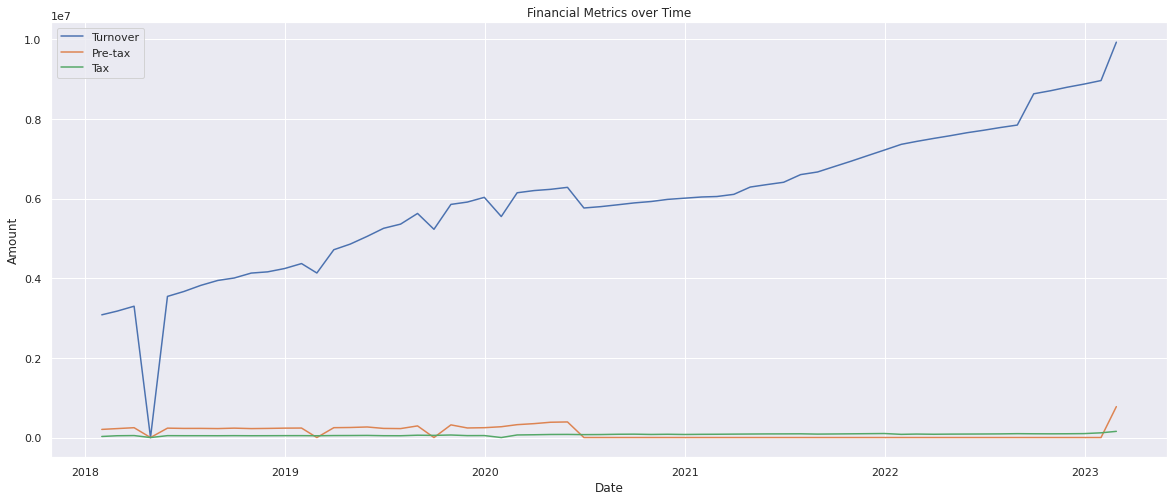

In [ ]:
# Set plot size
plt.figure(figsize=(20,8))

# Group by month and year
grouped = merged_df.groupby(pd.Grouper(freq='M')).sum()

# Plot line chart
plt.plot(grouped.index, grouped['Turnover'], label='Turnover')
plt.plot(grouped.index, grouped['Pre-tax'], label='Pre-tax')
plt.plot(grouped.index, grouped['Tax'], label='Tax')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Financial Metrics over Time')
plt.legend()

# Show the plot
plt.show()

<Figure size 1440x576 with 0 Axes>

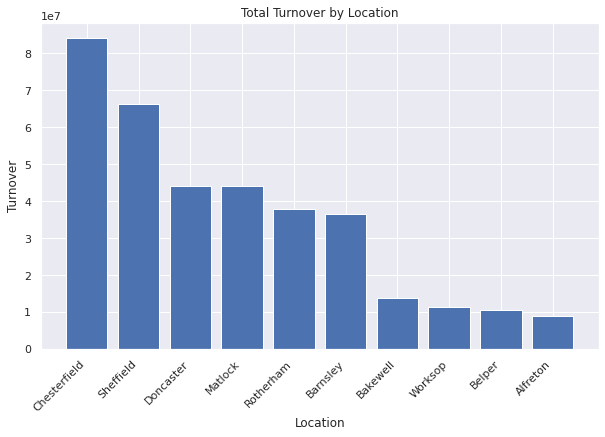

In [ ]:
# Set plot size
plt.figure(figsize=(20,8))

# Group data by location and calculate total turnover for each location
location_turnover = merged_df.groupby('Location')['Turnover'].sum().sort_values(ascending=False)

# Show only the top 10 locations
location_turnover = location_turnover[:10]

# Create bar plot
plt.figure(figsize=(10,6))
plt.bar(location_turnover.index, location_turnover.values)
plt.title('Total Turnover by Location')
plt.xlabel('Location')
plt.ylabel('Turnover')
plt.xticks(rotation=45, ha='right')
plt.show()

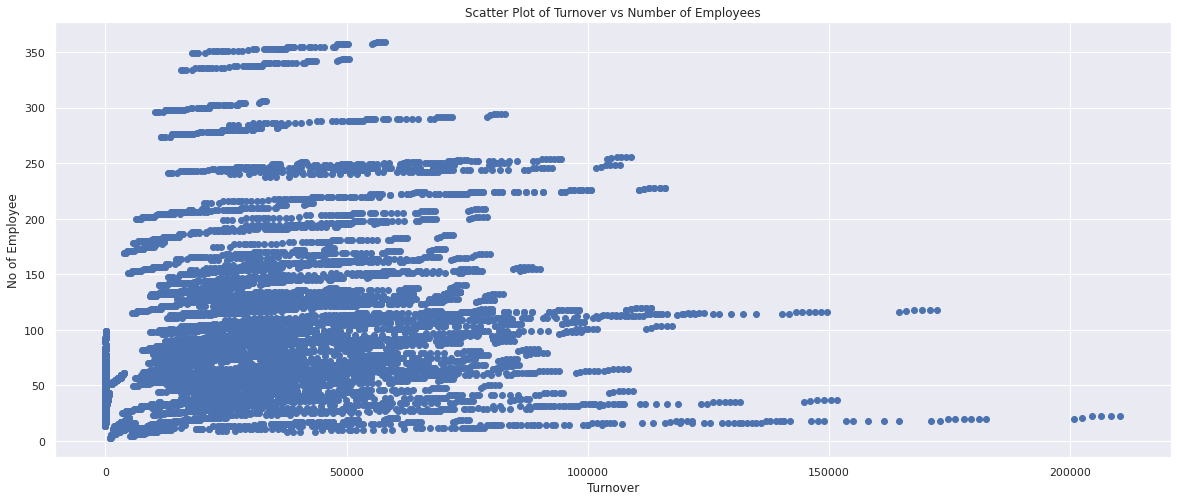

In [ ]:
# Set plot size
plt.figure(figsize=(20,8))

plt.scatter(merged_df['Turnover'], merged_df['No of Employee'])
plt.xlabel('Turnover')
plt.ylabel('No of Employee')
plt.title('Scatter Plot of Turnover vs Number of Employees')
plt.show()

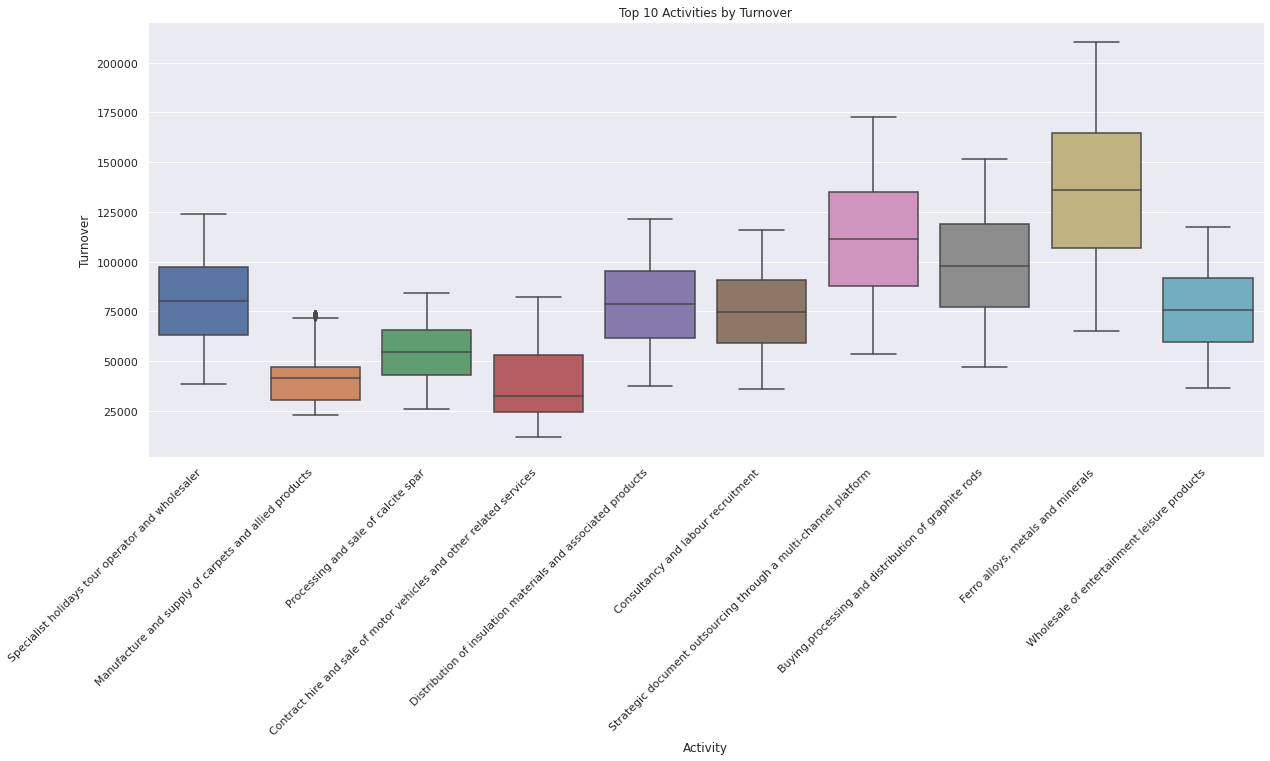

In [ ]:
# Set plot size
plt.figure(figsize=(20,8))

# Get the top 10 activities based on turnover
top_activities = merged_df.groupby('Activity')['Turnover'].sum().sort_values(ascending=False)[:10].index.tolist()

# Create boxplot for the top 10 activities
sns.boxplot(x="Activity", y="Turnover", data=merged_df[merged_df['Activity'].isin(top_activities)])
plt.title('Top 10 Activities by Turnover')
plt.xlabel('Activity')
plt.ylabel('Turnover')
plt.xticks(rotation=45, ha='right')
plt.show()

<AxesSubplot:xlabel='Month', ylabel='Location'>

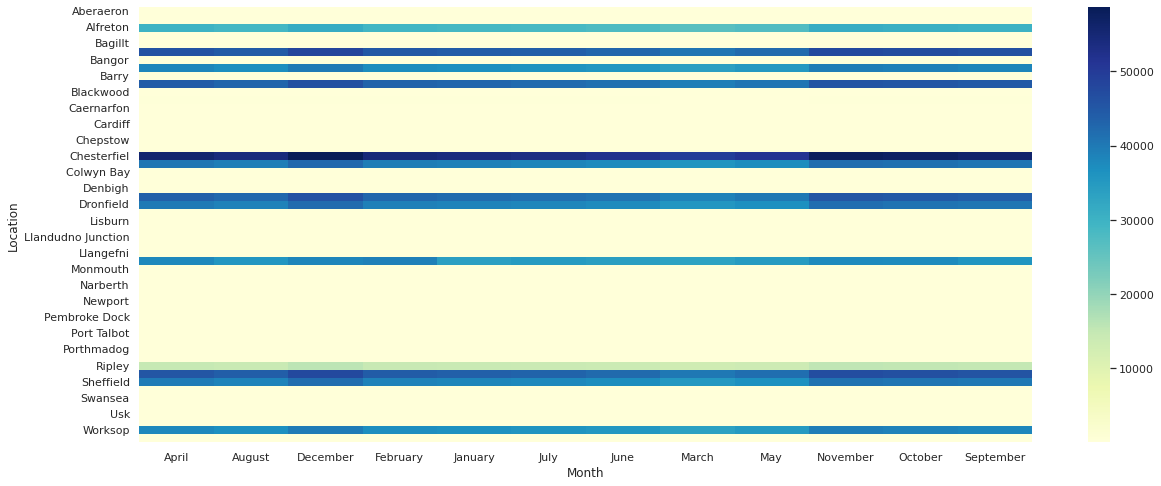

In [ ]:
# Set plot size
plt.figure(figsize=(20,8))

# Pivot the data to get the turnover by location and month
pivot_df = merged_df.pivot_table(values='Turnover', index='Location', columns='Month', aggfunc='mean')

# Create the heatmap
sns.heatmap(pivot_df, cmap='YlGnBu')

<Figure size 1440x576 with 0 Axes>

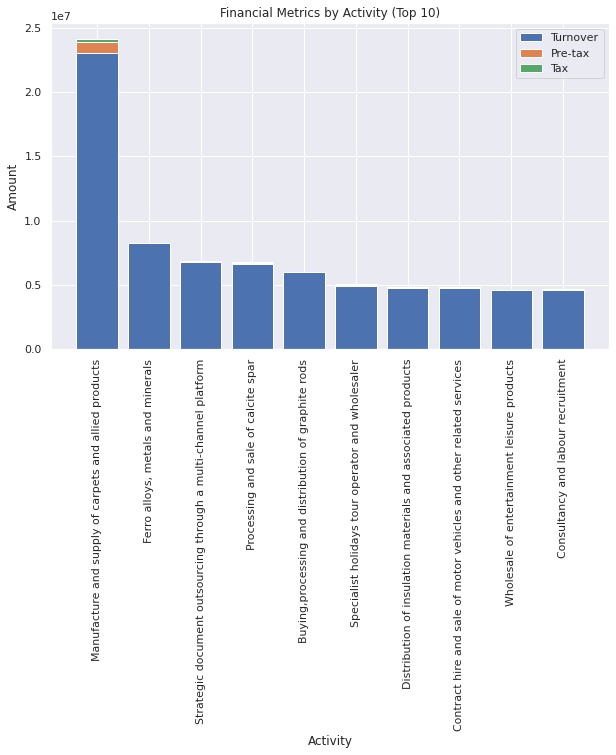

In [ ]:
# Set plot size
plt.figure(figsize=(20,8))

# Group the data by activity and calculate the total turnover, pre-tax, and tax for each activity
grouped = merged_df.groupby('Activity').agg({'Turnover': 'sum', 'Pre-tax': 'sum', 'Tax': 'sum'})

# Get the top 10 activities by turnover
top_activities = grouped.sort_values('Turnover', ascending=False)[:10]

# Create a stacked bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_activities.index, top_activities['Turnover'], label='Turnover')
plt.bar(top_activities.index, top_activities['Pre-tax'], bottom=top_activities['Turnover'], label='Pre-tax')
plt.bar(top_activities.index, top_activities['Tax'], bottom=top_activities['Turnover']+top_activities['Pre-tax'], label='Tax')
plt.xticks(rotation=90)
plt.xlabel('Activity')
plt.ylabel('Amount')
plt.legend()
plt.title('Financial Metrics by Activity (Top 10)')
plt.show()

## Data Preprocessing

In [ ]:
dates = merged_df.index.unique().tolist()
smes = merged_df.SMEs.unique().tolist()
smes_dict = {x: [] for x in smes}

for i in range(len(dates)):
    index = dates[i]
    index_str = index.strftime('%Y-%m-%d')
    condition1 = merged_df.index.date == index.date()
    date_df = merged_df.loc[condition1]

    # Reset index
    date_df = date_df.reset_index()

    for j in range(len(smes)):
        condition2 = date_df.SMEs == smes[j]
        sme_val = date_df.loc[condition2, 'Turnover']

        if sme_val.empty:
            smes_dict[smes[j]].append(np.nan)
        else:
            smes_dict[smes[j]].append(sme_val.values[0])

# Create new DataFrame
turnover_df = pd.DataFrame(smes_dict, index=dates)

In [ ]:
turnover_df.head()

,HERITAGE (NORTH WALES),ITEC TRAINING SOLUTIONS,CARPENTER & PATERSON,MARLIN INDUSTRIES,GROUNDHOG,VICTORIAN HOUSE (SALES),DAVID DAVIES (WHOLESALE DRAPERS),DAVID SPEAR COMMERCIALS,SUNDORNE PRODUCTS (LLANIDLOES),GARRISON BARCLAY EQUITY,GWINDY 2012 (T/A JR Industries),S&K HAULAGE (GLAMORGAN),GAIA TECHNOLOGIES,KATHRENS,RYLO,FINANCE WALES,SOLAR WINDOWS,CORNELIUS,BAKERFIELD (WALES),MONOLITHIC REFRACTORIES,HOLLINGSWORTH BROS (UK),VILLAGE BAKERY (COEDPOETH),RED RECRUITMENT PARTNERSHIP,RICHARD WILLIAMS (DEGANWY),WYNNE-WILLIAMS (FLINT),DIRECT HEALTHCARE SERVICES,SOURCE INSURANCE,WELSH SAUSAGE,FARRALLS TRANSPORT (PROPERTIES),PINACL,DELFIN INVESTMENTS,GENQUIP,GLT EXPORTS,BLUE BAY BUILDING PRODUCTS,METLAB SUPPLIES,WALDON,SPECIALISED WIRING ACCESSORIES,VALE HOLIDAY PARKS,GLENSIDE COMMERCIALS,INTERFRAME (SOUTH WEST),GREENCOAT,A&N LEWIS,WESTCO,PACHUCA (T/A Dudleys Aluminium),RK AGGARWAL,FWG SALES,PRECISION MANUFACTURING SOLUTIONS,EVADX,VIBRANT ENERGY MATTERS,BALMCREST HOMES,MINTON TREHARNE & DAVIES,PUMP SUPPLIES,WELCOME,RHINO PRODUCTS,ESKDALEMUIR FORESTRY,PARAMOUNT OFFICE INTERIORS,CMC PARTNERSHIP (UK),ENCON CONSTRUCTION,CL JONES (HOLDING),CHEMSPEC (EAST ANGLIA),VITTORIA HEALTHCARE,MONTAGNE JEUNESSE INTERNATIONAL,COMPLETE CORE BUSINESS SOLUTIONS,BOF,CCP BUILDING PRODUCTS,EVANS WILSON AND EVANS,WE DOWDS (SHIPPING),GTS FLEXIBLE MATERIALS,JONES ENVIRONMENTAL FORENSICS,CAMBRIAN LODGES,CELTIC ENGINEERING,JOHN THOMAS (ABERAERON),CLWYDIAN,FIBRAX,MARCO GEARING,PRINCES GATE WATER,COMVERGENT,JOHN COLLINS & PARTNERS,BRADLEYS' PROPERTIES,DM BEVAN,CLOGAU GOLD OF WALES,GREENTHUMB,FLAME HOMEWARE,MMR,KJ SERVICES,COMPOSITE METAL FLOORING,FAMILY FINANCE,CWMTILLERY GLASS CENTRE,ALTARVEST,COWINDALE FEEDS,TDKP,CRIPPETTS (T/A SCI-MX Nutrition),TEMPO INSULATION SERVICES,FRANK SUTTON,JENNINGS BUILDING & CIVIL ENGINEERING,DINGLE NURSERIES,SHINE FOOD MACHINERY,GERRY JONES TRANSPORT SERVICES,NHC,HAYES (WALES),Glass Recycling,Moorhen,Haywood And Padgett,Derbyshire Aggregates,1 SCX Special Projects,Clear Line,Clee Hill Plant,Tours Abroad Group,Cidon,Eco-Power Environmental,Dransfield Properties Investments,Norton Finance Group,Wild Life Group,National Floorcoverings Group,Long Rake Spar Company,Lablogic Group,IFA Metals International,Robinson Healthcare Group,Utopia,Westdale Group,Go Green,Roy Hatfield,Liberty Group,OSL Group,8point8 Support,MB Group,Talasey,Kybotech,Roofdec,Rotor Clip,History & Heraldry,Morris & CO.,IVY Cottage,Haughton Textiles,Bridgstock,A.E.Spink,Carver Engineering,DSS Group,Dearneside Fabrications,Wordsworth Excavations,Ronald Hull Jnr.,Asmet,GO2 Foods,Panache Lingerie,GRI Libra,Pinelog Group,Roe Developments,Minorfern,Braithwaite Excavations,Warwick Ward,X-Cel Superturn,Wilsons Furnishers,Thos.Winnard & Sons,URA Ventures,SRS Rail System,SPD,Portland of Bawtry,Tickhill Engineering Company,Penny Hydraulics,Direct Trade,Intake Developments,BDB Design Build,Galaxy Insulation And DRY Lining,Compass Engineering,Excel Parking Services,Breasley Pillows,Johnson Bros,HRE Newco,Gdma Group,Plumbing Supplies Company,Raveningham,Mac's Transport,Planet X,Panel Systems,One Health Group,A Shade Greener,Rotherham Healthcare,Jepson,E.E.Blyth & CO,Apollo Access,Lidget Compton,Navartis,Vidlearn,Millgate,QWP,Datagraphic,Green Group International,The Abbey Group UK,Saul Construction,Kingfield Electronics,Sargents Properties,BEN Bennett JR,Loadhog,Milner,Fosters Bakery,AEW Paddock Motors,Paragon Foodservice,B.J. Waters,McGhee Holdings,Moorhen Holdings,Bailey Construction (Derby) Holdings,Long Rake Spar Company (The),Tennant Metallurgical Group Holdings,Utopia Holdings (Chesterfield),WCEC Group,Capital Refractories,Garner Holdings,SRS Rail System (Holdings),J C Balls & Sons,Tickford Orange,M. M. D. Design and Consultancy,Richford Motor Services Limited,Breasley Pillows (The),Johnson Bros (Tours) Limited,Plumbing Supplies Company Ltd,Moto Direct Holdings,Ondrives Group,Datagraphic Holdings,Milner Holdings (Matlock),Lubricant Holdings,Watson Trade,Restek-Uk,Weavers Close,Nord

In [ ]:
# Choosing one company
turnover_df = turnover_df.iloc[:,:1]

# Renaming first column
# turnover_df = turnover_df.rename(columns={'HERITAGE (NORTH WALES)': 'Turnover'})

turnover_df.head()

,HERITAGE (NORTH WALES)
2018-01-01,14.30
2018-02-01,14.73
2018-03-01,15.30
2018-05-01,16.45
2018-06-01,17.02


In [ ]:
turnover_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2018-01-01 to 2023-02-01
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   HERITAGE (NORTH WALES)  61 non-null     float64
dtypes: float64(1)
memory usage: 976.0 bytes


## Modelling

### LSTM Model

In [ ]:
len(turnover_df.columns.tolist())

235

In [ ]:
# Prepare the data
num_companies = len(turnover_df.columns)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(turnover_df.values)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Define the function to prepare the input and output data for LSTM model
def prepare_data(timeseries_data, num_steps):
    X, y = [], []
    for i in range(len(timeseries_data)-num_steps):
        X.append(timeseries_data[i:i+num_steps, :])
        y.append(timeseries_data[i+num_steps, :])
    return np.array(X), np.array(y)

# Prepare the input and output data for LSTM model
num_steps = 7  # number of timesteps to look back
X_train, y_train = prepare_data(train_data, num_steps)
X_test, y_test = prepare_data(test_data, num_steps)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], num_companies)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(num_companies))
model.compile(loss='mse', optimizer='adam')

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the LSTM model
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Train Score:', train_score)
print('Test Score:', test_score)

Epoch 1/100
2/2 [==============================] - 7s 20ms/step - loss: 0.2189
Epoch 2/100
2/2 [==============================] - 0s 14ms/step - loss: 0.2003
Epoch 3/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1828
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1611
Epoch 5/100
2/2 [==============================] - 0s 15ms/step - loss: 0.1373
Epoch 6/100
2/2 [==============================] - 0s 15ms/step - loss: 0.1140
Epoch 7/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0935
Epoch 8/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0760
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0616
Epoch 10/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0501
Epoch 11/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0385
Epoch 12/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0291
Epoch 13/100
2/2 [==============================]

In [ ]:
# make predictions on test data
y_pred = model.predict(X_test)

# calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

# calculate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

1/1 [==============================] - 1s 1s/step
MAE: 0.12207549927798747
RMSE: 0.12981311511943053


In [ ]:
test_dict = {x:[] for x in range(len(y_test[0]))}
pred_dict = {x:[] for x in range(len(y_pred[0]))}

for i in range(len(y_test)):
    for j in range(len(y_test[i])):
        test_dict[j].append(y_test[i][j])
        pred_dict[j].append(y_pred[i][j])

In [ ]:
# initialize lists to store the Error scores for each company
mape_list = []
me_list = []
mae_list = []
mpe_list = []
corr_list = []
rmse_list = []
mins_list = []
maxs_list = []
minmax_list = []

for i in pred_dict.keys():

    # convert the lists to numpy arrays
    pred_values = np.array(pred_dict[i])
    test_values = np.array(test_dict[i])

    # calculate the Error Scores for this company
    mape = np.mean(np.abs(pred_values - test_dict[i])/np.abs(test_values))  # MAPE
    me = np.mean(pred_values - test_values)             # ME
    mae = np.mean(np.abs(pred_values - test_values))    # MAE
    mpe = np.mean((pred_values - test_values)/test_values)   # MPE
    rmse = np.mean((pred_values - test_values)**2)**.5  # RMSE
    corr = np.corrcoef(pred_values, test_values)[0,1]   # corr
    mins = np.amin(np.hstack([pred_values[:,None], test_values[:,None]]), axis=1)
    maxs = np.amax(np.hstack([pred_values[:,None], test_values[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(model_fit.resid, nlags=1, fft=False)[1] #ACF1

    # append the results to the lists
    mape_list.append(mape)
    me_list.append(me)
    mae_list.append(mae)
    mpe_list.append(mpe)
    corr_list.append(corr)
    rmse_list.append(rmse)
    mins_list.append(mins)
    maxs_list.append(maxs)
    minmax_list.append(minmax)

# calculate the average and median for all the specified lists
avg_mape = sum(mape_list) / len(mape_list)
median_mape = np.median(mape_list)
mean_me = sum(me_list) / len(me_list)
median_me = np.median(me_list)
avg_mae = sum(mae_list) / len(mae_list)
median_mae = np.median(mae_list)
mean_mpe = sum(mpe_list) / len(mpe_list)
median_mpe = np.median(mpe_list)
mean_corr = sum(corr_list) / len(corr_list)
median_corr = np.median(corr_list)
avg_rmse = sum(rmse_list) / len(rmse_list)
median_rmse = np.median(rmse_list)
mean_mins = sum(mins_list) / len(mins_list)
median_mins = np.median(mins_list)
mean_maxs = sum(maxs_list) / len(maxs_list)
median_maxs = np.median(maxs_list)
mean_minmax = sum(minmax_list) / len(minmax_list)
median_minmax = np.median(minmax_list)

# print the results
print("Average MAPE: ", avg_mape)
print("Median MAPE: ", median_mape)
print("Average ME: ", mean_me)
print("Median ME: ", median_me)
print("Average MAE: ", avg_mae)
print("Median MAE: ", median_mae)
print("Average MPE: ", mean_mpe)
print("Median MPE: ", median_mpe)
print("Average Corr: ", mean_corr)
print("Median Corr: ", median_corr)
print("Average RMSE: ", avg_rmse)
print("Median RMSE: ", median_rmse)
print("Average Mins: ", mean_mins)
print("Median Mins: ", median_mins)
print("Average Maxs: ", mean_maxs)
print("Median Maxs: ", median_maxs)
print("Average Minmax: ", mean_minmax)
print("Median Minmax: ", median_minmax)

Average MAPE:  0.12629917845332433
Median MAPE:  0.12453438302780506
Average ME:  -0.12207549927798736
Median ME:  -0.12036236029311531
Average MAE:  0.12207549927798736
Median MAE:  0.12036236029311531
Average MPE:  -0.12629917845332433
Median MPE:  -0.12453438302780506
Average Corr:  0.9903435623132449
Median Corr:  0.9908219348049829
Average RMSE:  0.12220821585626189
Median RMSE:  0.12040973974291339
Average Mins:  [0.81091167 0.82795684 0.84146705 0.85303259 0.86284365 0.8712793 ]
Median Mins:  0.8437671363353729
Average Maxs:  [0.93371589 0.94618732 0.96015    0.97283606 0.98705485 1.        ]
Median Maxs:  0.9665839424393781
Average Minmax:  0.12629917845332433
Median Minmax:  0.12453438302780506


In [ ]:
lstm_df = pd.DataFrame({
    'Company': turnover_df.columns.tolist(),
    'mape': mape_list,
    'me': me_list,
    'mae': mae_list,
    'mpe': mpe_list,
    'rmse': rmse_list,
    'corr': corr_list,
    'mins': mins_list,
    'maxs': maxs_list,
    'minmax': minmax_list
})


In [ ]:
lstm_df

,Company,mape,me,mae,mpe,rmse,corr,mins,maxs,minmax
0,HERITAGE (NORTH WALES),0.117520,-0.113566,0.113566,-0.117520,0.113618,0.989772,"[0.8177425265312195, 0.8356797695159912, 0.850...","[0.9335851432168714, 0.9461756373937678, 0.960...",0.117520
1,ITEC TRAINING SOLUTIONS,0.104882,-0.101378,0.101378,-0.104882,0.101445,0.988458,"[0.8301122188568115, 0.8481577634811401, 0.862...","[0.9337114498404822, 0.946118397731301, 0.9602...",0.104882
2,CARPENTER & PATERSON,0.134583,-0.130093,0.130093,-0.134583,0.130171,0.990380,"[0.8048163652420044, 0.8204705119132996, 0.833...","[0.9335753176043555, 0.9459165154264972, 0.960...",0.134583
3,MARLIN INDUSTRIES,0.170060,-0.164439,0.164439,-0.170060,0.164574,0.986064,"[0.7738193869590759, 0.788768470287323, 0.8002...","[0.9339049660593071, 0.9460521614862449, 0.959...",0.170060
4,GROUNDHOG,0.144309,-0.139550,0.139550,-0.144309,0.139706,0.993271,"[0.8006054162979126, 0.8128989338874817, 0.824...","[0.933728981206726, 0.9460929772502473, 0.9599...",0.144309
...,...,...,...,...,...,...,...,...,...,...
230,B.J.Waters (Transport),0.195058,-0.188593,0.188593,-0.195058,0.188704,0.991170,"[0.750558078289032, 0.7644436955451965, 0.7754...","[0.9337242928131633, 0.9461790937843491, 0.960...",0.195058
231,Owen Taylor And,0.182838,-0.176735,0.176735,-0.182838,0.176801,0.989710,"[0.7584970593452454, 0.7748615741729736, 0.787...","[0.9337243988971436, 0.9461792808843387, 0.960...",0.182838
232,Filigree Holdings,0.068420,-0.065961,0.065961,-0.068420,0.066343,0.990805,"[0.8532190322875977, 0.8773330450057983, 0.896...","[0.9337240488625154, 0.9461791800734067, 0.960...",0.068420
233,Container Components Europe,0.189549,-0.183329,0.183329,-0.189549,0.183538,0.991609,"[0.7600948214530945, 0.7714158296585083, 0.781...","[0.9337241997626508, 0.9461792887141852, 0.960...",0.189549


### ARIMA

In [ ]:
cols = turnover_df.columns.tolist()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

#### Assumption Check

##### p-value

In [ ]:
# checking p-value
for i in range(len(cols)):
  result = adfuller(turnover_df.iloc[:,i].values)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('\n')

ADF Statistic: 0.120604
p-value: 0.967440


ADF Statistic: 0.116849
p-value: 0.967193


ADF Statistic: 0.121081
p-value: 0.967471


ADF Statistic: 0.117125
p-value: 0.967211


ADF Statistic: 0.120008
p-value: 0.967401


ADF Statistic: 0.120992
p-value: 0.967465


ADF Statistic: 0.117779
p-value: 0.967254


ADF Statistic: 0.120705
p-value: 0.967447


ADF Statistic: 0.116437
p-value: 0.967166


ADF Statistic: 0.118092
p-value: 0.967275


ADF Statistic: 0.117316
p-value: 0.967224


ADF Statistic: 0.120161
p-value: 0.967411


ADF Statistic: 0.116251
p-value: 0.967153


ADF Statistic: 0.117453
p-value: 0.967233


ADF Statistic: 0.115997
p-value: 0.967136


ADF Statistic: 0.116359
p-value: 0.967160


ADF Statistic: 0.116452
p-value: 0.967167


ADF Statistic: 0.117779
p-value: 0.967254


ADF Statistic: 0.115660
p-value: 0.967114


ADF Statistic: 0.119011
p-value: 0.967335


ADF Statistic: 0.120604
p-value: 0.967440


ADF Statistic: 0.119421
p-value: 0.967362


ADF Statistic: 0.119421
p-value:

##### Order of Differencing (d)

------------------------------------------------------------------------------------------------------------------------------------------

Order Of Differencing (d) for: HERITAGE (NORTH WALES)

------------------------------------------------------------------------------------------------------------------------------------------



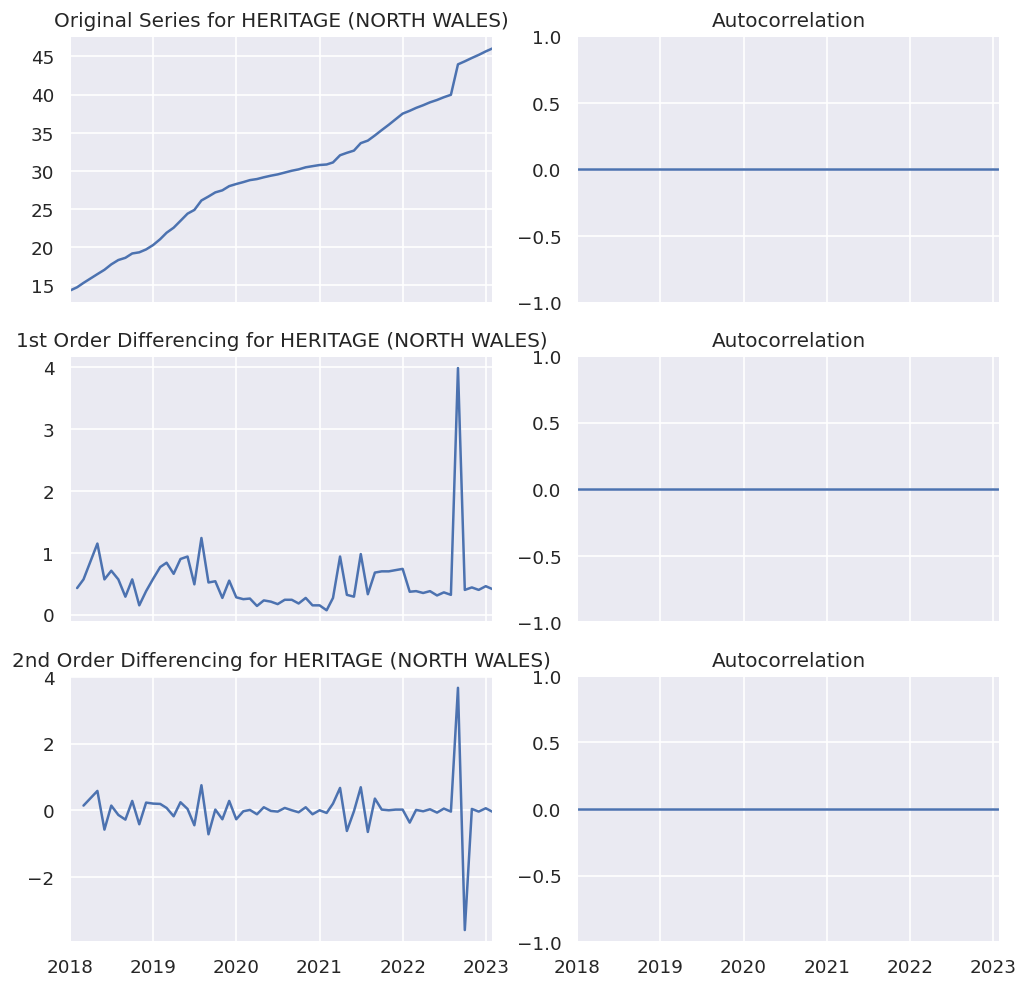

In [ ]:
# Order of differencing

for i in range(len(cols)):

  print('------------------------------------------------------------------------------------------------------------------------------------------\n')
  print(f'Order Of Differencing (d) for: {cols[i]}\n')
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')

  # Original Series
  fig, axes = plt.subplots(3, 2, sharex=True, figsize=(10, 10))
  axes[0, 0].plot(turnover_df.index, turnover_df[cols[i]].values); axes[0, 0].set_title(f'Original Series for {cols[i]}')
  plot_acf(turnover_df[cols[i]].values, ax=axes[0, 1])

  # 1st Differencing
  axes[1, 0].plot(turnover_df.index, turnover_df[cols[i]].diff().values); axes[1, 0].set_title(f'1st Order Differencing for {cols[i]}')
  plot_acf(turnover_df[cols[i]].diff().dropna().values, ax=axes[1, 1])

  # 2nd Differencing
  axes[2, 0].plot(turnover_df.index, turnover_df[cols[i]].diff().diff().values); axes[2, 0].set_title(f'2nd Order Differencing for {cols[i]}')
  plot_acf(turnover_df[cols[i]].diff().diff().dropna().values, ax=axes[2, 1])

  # Set x-axis limits to range of years in dataset
  axes[0, 0].set_xlim(turnover_df.index.min(), turnover_df.index.max())
  axes[1, 0].set_xlim(turnover_df.index.min(), turnover_df.index.max())
  axes[2, 0].set_xlim(turnover_df.index.min(), turnover_df.index.max())

  plt.show()
  break

In [ ]:
# Setting order of difference (d) value
d = 1

##### Order of AR Term (p)

------------------------------------------------------------------------------------------------------------------------------------------

Order Of AR Term (p) for: HERITAGE (NORTH WALES)

------------------------------------------------------------------------------------------------------------------------------------------



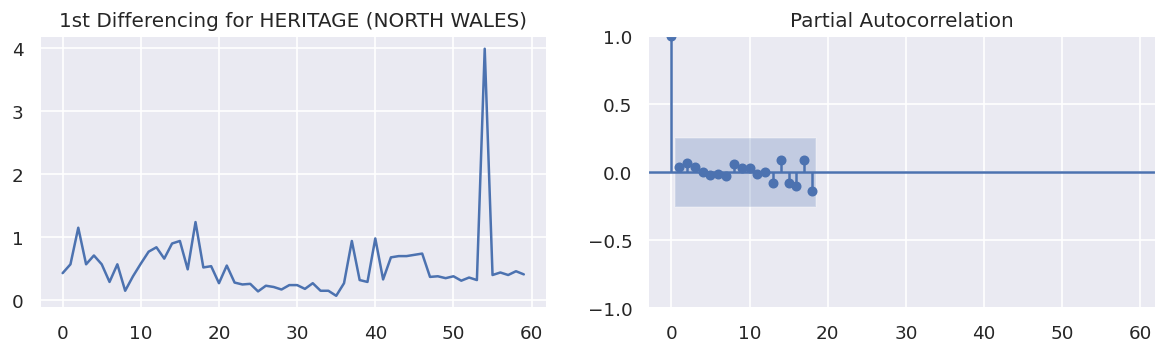

In [ ]:
# order Of AR Term (p)

for i in range(len(cols)):

  print('------------------------------------------------------------------------------------------------------------------------------------------\n')
  print(f'Order Of AR Term (p) for: {cols[i]}\n')
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')

  # plot AR term
  fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 3))
  axes[0].plot(turnover_df[cols[0]].diff().dropna().values); axes[0].set_title(f'1st Differencing for {cols[i]}')
  axes[1].set(ylim=(0,5))
  plot_pacf(turnover_df[cols[0]].diff().dropna().values, ax=axes[1])

  plt.show()
  break

In [ ]:
# Setting order of AR Term value
p = 1

##### Order of MA Term (q)

------------------------------------------------------------------------------------------------------------------------------------------

Order Of MA Term (q) for: HERITAGE (NORTH WALES)

------------------------------------------------------------------------------------------------------------------------------------------



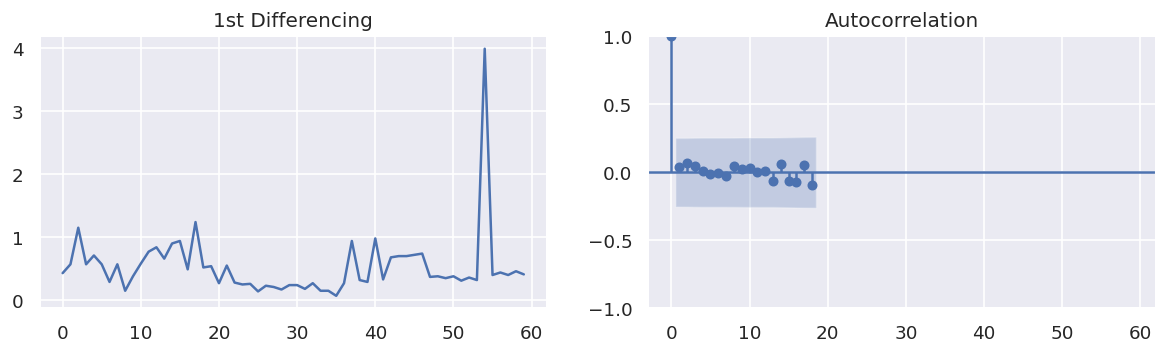

In [ ]:
# Order of MA Term (q)
for i in range(len(cols)):
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')
  print(f'Order Of MA Term (q) for: {cols[i]}\n')
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')

  # plot MA term
  fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 3))
  axes[0].plot(turnover_df[cols[0]].diff().dropna().values); axes[0].set_title('1st Differencing')
  axes[1].set(ylim=(0,5))
  plot_acf(turnover_df[cols[0]].diff().dropna().values, ax=axes[1])

  plt.show()
  break

In [ ]:
# Setting order of MA Term value
q = 1

#### Model Identification

In [ ]:
# define the train/test split ratio
split_ratio = 0.8

# define the order of the ARIMA model
order = (p, d, q)

# dictionary to hold trained models
models_dict = {}

# dictionary to hold trained models predictions
models_pred = {}

# dictionary to hold trained models train/test data
models_data = {}

# initialize lists to store the Error scores for each company
mape_list = []
me_list = []
mae_list = []
mpe_list = []
corr_list = []
rmse_list = []
mins_list = []
maxs_list = []
minmax_list = []


# loop through each company
for company in turnover_df.columns:

    print('------------------------------------------------------------------------------------------------------------------------------------------\n')
    print(f'Predicting for: {company}\n')
    print('------------------------------------------------------------------------------------------------------------------------------------------\n')

    # split the data into train and test sets
    n = len(turnover_df[company])
    split_index = int(n * split_ratio)
    train_data = turnover_df[company][:split_index]
    test_data = turnover_df[company][split_index:]
    models_data[company] = [train_data, test_data]

    # fit an ARIMA model on the training data
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    print(model_fit.summary())
    models_dict[company] = model_fit

    # Make predictions on the test data
    preds = model_fit.forecast(steps=len(test_data))
    preds_values = preds.values
    models_pred[company] = preds

    # calculate the Error Scores for this company
    mape = np.mean(np.abs(preds_values - test_data)/np.abs(test_data))  # MAPE
    me = np.mean(preds_values - test_data)             # ME
    mae = np.mean(np.abs(preds_values - test_data))    # MAE
    mpe = np.mean((preds_values - test_data)/test_data)   # MPE
    rmse = np.mean((preds_values - test_data)**2)**.5  # RMSE
    corr = np.corrcoef(preds_values, test_data)[0,1]   # corr
    mins = np.amin(np.hstack([preds_values[:,None], test_data[:,None]]), axis=1)
    maxs = np.amax(np.hstack([preds_values[:,None], test_data[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(model_fit.resid, nlags=1, fft=False)[1] #ACF1

    # append the results to the lists
    mape_list.append(mape)
    me_list.append(me)
    mae_list.append(mae)
    mpe_list.append(mpe)
    corr_list.append(corr)
    rmse_list.append(rmse)
    mins_list.append(mins)
    maxs_list.append(maxs)
    minmax_list.append(minmax)
    print('\n')
    break

------------------------------------------------------------------------------------------------------------------------------------------

Predicting for: HERITAGE (NORTH WALES)

------------------------------------------------------------------------------------------------------------------------------------------

                                 SARIMAX Results                                  
Dep. Variable:     HERITAGE (NORTH WALES)   No. Observations:                   48
Model:                     ARIMA(1, 1, 1)   Log Likelihood                  -4.336
Date:                    Tue, 07 Mar 2023   AIC                             14.672
Time:                            07:57:54   BIC                             20.223
Sample:                                 0   HQIC                            16.761
                                     - 48                                         
Covariance Type:                      opg                                         
                

#### Model Estimation

In [ ]:
# calculate the average and median for all the specified lists
avg_mape = sum(mape_list) / len(mape_list)
median_mape = np.median(mape_list)
mean_me = sum(me_list) / len(me_list)
median_me = np.median(me_list)
avg_mae = sum(mae_list) / len(mae_list)
median_mae = np.median(mae_list)
mean_mpe = sum(mpe_list) / len(mpe_list)
median_mpe = np.median(mpe_list)
mean_corr = sum(corr_list) / len(corr_list)
median_corr = np.median(corr_list)
avg_rmse = sum(rmse_list) / len(rmse_list)
median_rmse = np.median(rmse_list)
mean_mins = sum(mins_list) / len(mins_list)
median_mins = np.median(mins_list)
mean_maxs = sum(maxs_list) / len(maxs_list)
median_maxs = np.median(maxs_list)
mean_minmax = sum(minmax_list) / len(minmax_list)
median_minmax = np.median(minmax_list)

# print the results
print("Average MAPE: ", avg_mape)
print("Median MAPE: ", median_mape)
print("Average ME: ", mean_me)
print("Median ME: ", median_me)
print("Average MAE: ", avg_mae)
print("Median MAE: ", median_mae)
print("Average MPE: ", mean_mpe)
print("Median MPE: ", median_mpe)
print("Average Corr: ", mean_corr)
print("Median Corr: ", median_corr)
print("Average RMSE: ", avg_rmse)
print("Median RMSE: ", median_rmse)
print("Average Mins: ", mean_mins)
print("Median Mins: ", median_mins)
print("Average Maxs: ", mean_maxs)
print("Median Maxs: ", median_maxs)
print("Average Minmax: ", mean_minmax)
print("Median Minmax: ", median_minmax)

Average MAPE:  0.030787178135582655
Median MAPE:  0.031148821884115156
Average ME:  -869.4853481607498
Median ME:  -192.17914098461188
Average MAE:  1199.9641959073194
Median MAE:  826.5616172049989
Average MPE:  -0.007775304258731219
Median MPE:  -0.005212915328862046
Average Corr:  0.9529377232959467
Median Corr:  0.9546571439450648
Average RMSE:  1564.2701193957926
Median RMSE:  889.136327932281
Average Mins:  [28269.67680851 28552.37323404 28809.34497872 29097.43825532
 29330.21765957 29594.18974468 29830.94331915 30648.7589056
 30940.86014688 31224.97709179 31501.37044665 31770.29142552
 32031.98211733]
Median Mins:  24701.71
Average Maxs:  [28356.41288887 28712.58582746 29058.64951196 29394.94274795
 29721.79181108 30039.51093621 30348.40278682 32814.03706383
 33109.36417021 33440.45765957 33741.42195745 34078.83578723
 34385.54553191]
Median Maxs:  25178.729044784664
Average Minmax:  0.03043466061993842
Median Minmax:  0.03078394406069862


In [ ]:
arima_df = pd.DataFrame({'Company':turnover_df.columns.tolist(),
                         'mape':mape, 'me':me, 'mae': mae,
                         'mpe': mpe, 'rmse':rmse, #'acf1':acf1,
                         'corr':corr, 'minmax':minmax})

In [ ]:
arima_df

,Company,mape,me,mae,mpe,rmse,corr,minmax
0,HERITAGE (NORTH WALES),0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
1,ITEC TRAINING SOLUTIONS,0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
2,CARPENTER & PATERSON,0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
3,MARLIN INDUSTRIES,0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
4,GROUNDHOG,0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
...,...,...,...,...,...,...,...,...
230,B.J.Waters (Transport),0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
231,Owen Taylor And,0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
232,Filigree Holdings,0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227
233,Container Components Europe,0.03254,-325.962463,1010.69993,-0.008465,1109.65519,0.950306,0.032227


#### Model Diagnosis

------------------------------------------------------------------------------------------------------------------------------------------

Plotting for: HERITAGE (NORTH WALES)

------------------------------------------------------------------------------------------------------------------------------------------



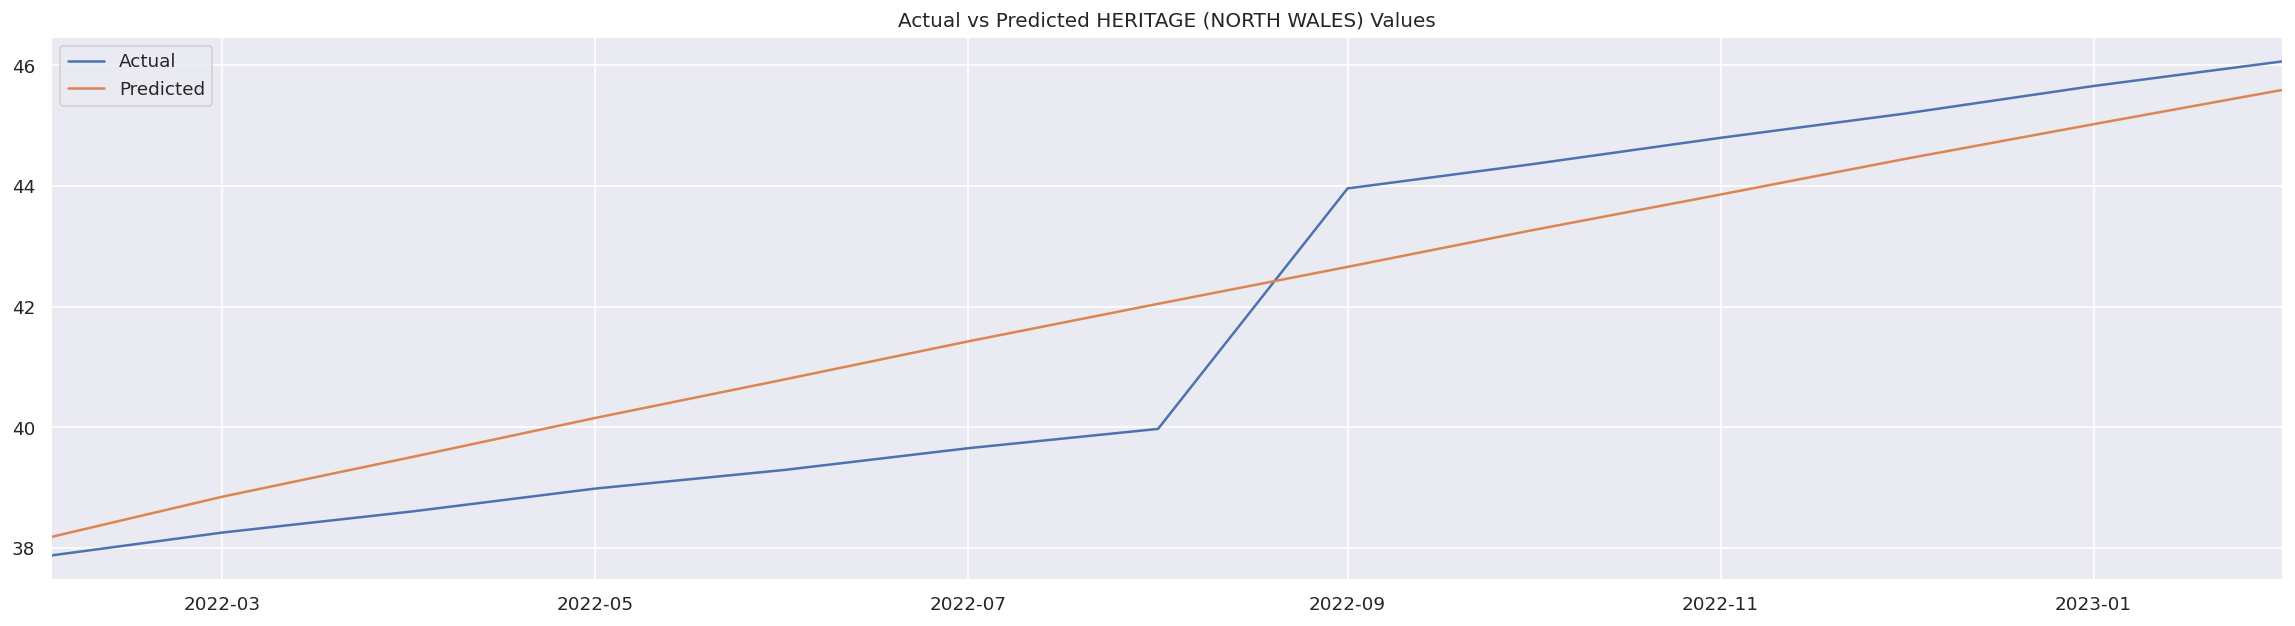

In [ ]:
# Predictions vs Actual
for i in models_dict.keys():
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')
  print(f'Plotting for: {i}\n')
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')

  plot_df = pd.DataFrame({'Actual':models_data[i][1].values,
                'Predicted': models_pred[i].values}, index=models_data[i][1].index)

  plt.figure(figsize=(24,6))
  plt.title(f'Actual vs Predicted {i} Values')
  plt.plot(plot_df.Actual, label='Actual')
  plt.plot(plot_df.Predicted, label='Predicted')
  plt.legend()
  plt.xlim(plot_df.index.min(), plot_df.index.max())
  plt.show()

  print('\n')
  break

------------------------------------------------------------------------------------------------------------------------------------------

Plotting for: HERITAGE (NORTH WALES)

------------------------------------------------------------------------------------------------------------------------------------------



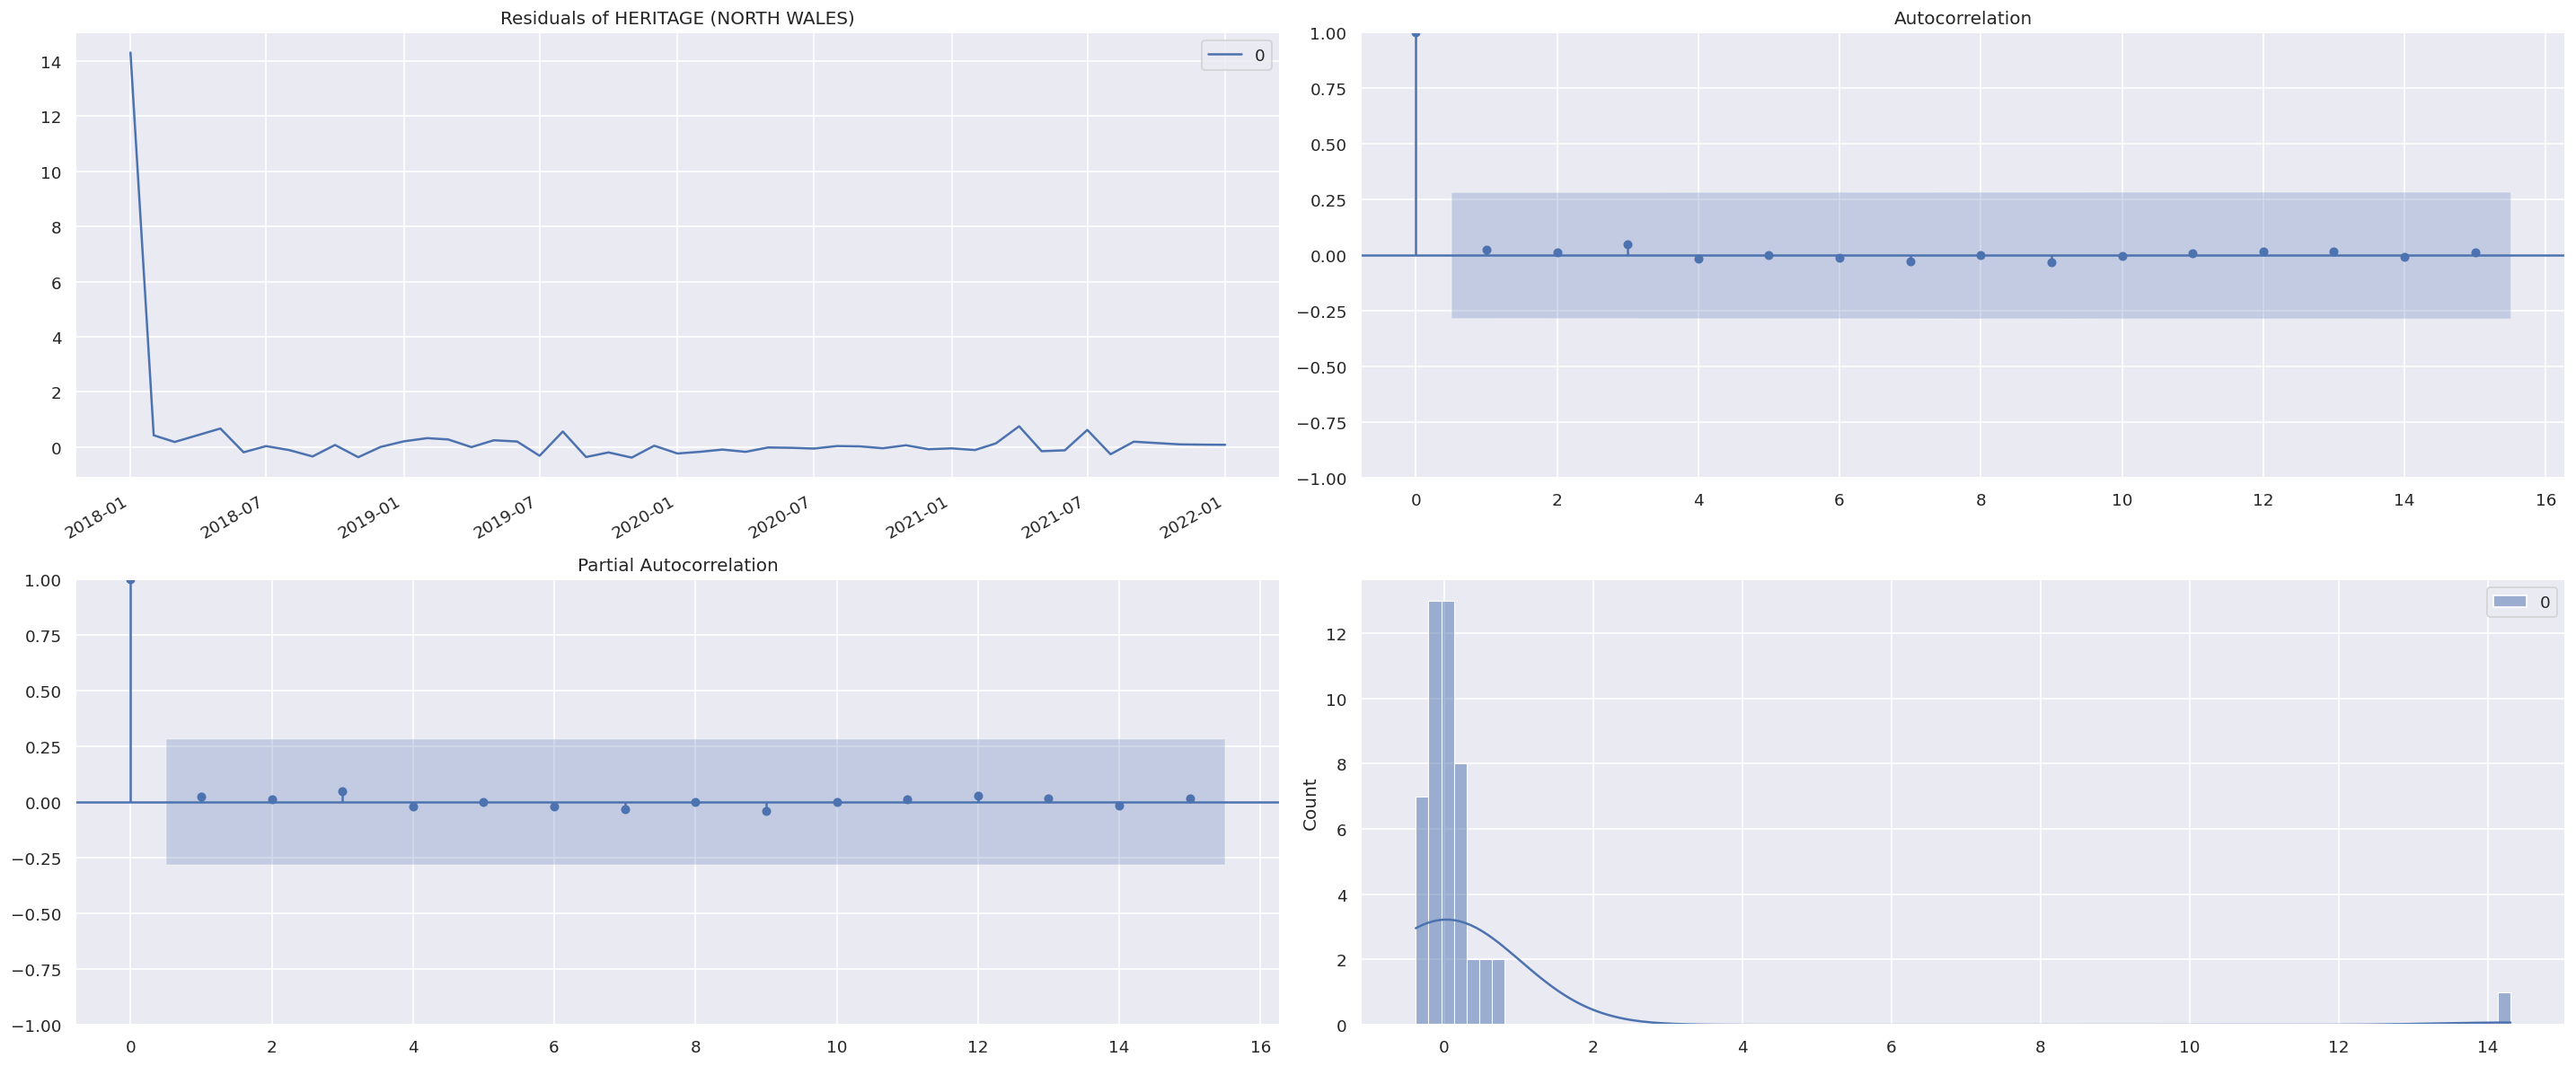

In [ ]:
# diagnosis
for i in models_dict.keys():
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')
  print(f'Plotting for: {i}\n')
  print('------------------------------------------------------------------------------------------------------------------------------------------\n')
  # plot model diagnostics
  residuals = pd.DataFrame(models_dict[i].resid)
  fig, axes = plt.subplots(2, 2, figsize=(24, 10))

  # plot residuals
  residuals.plot(title=f'Residuals of {i}', ax=axes[0, 0])

  # plot ACF of residuals
  plot_acf(residuals, ax=axes[0, 1], lags=15)

  # plot PACF of residuals
  plot_pacf(residuals, ax=axes[1, 0], lags=15)

  # plot histogram and KDE of residuals
  sns.histplot(residuals, ax=axes[1, 1], kde=True)

  plt.tight_layout()
  plt.show()

  print('\n')
  break